# Data Munging Workflow

In [1]:
from __future__ import print_function
__author__= 'Cyrus Blankinship'

import os

#Data handling
import numpy as np
import pandas as pd
# from sodapy import Socrata

#Spatial data handling
import geopandas as gpd
import shapely
from fiona.crs import from_epsg
import pysal as ps

#Downloading data
import requests
try:
    import urllib2 as urlib
except ImportError:
    import urllib as urlib

#Also needed for parsing downloaded data sometimes
try:
    import StringIO as io
except ImportError:
    import io

#For reading json data
import json

#For plotting
import matplotlib.pylab as plt
import seaborn as sns
sns.set(context='notebook', style='whitegrid', palette='deep', font='DejaVu Sans', font_scale=1.2, rc=None)
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
# #!/usr/bin/env python

# # make sure to install these packages before running:
# # pip install pandas
# # pip install sodapy



# # Unauthenticated client only works with public data sets. Note 'None'
# # in place of application token, and no username or password:
# client = Socrata("data.cityofnewyork.us", None)

# # Example authenticated client (needed for non-public datasets):
# # client = Socrata(data.cityofnewyork.us,
# #                  MyAppToken,
# #                  userame="user@example.com",
# #                  password="AFakePassword")

# # First 2000 results, returned as JSON from API / converted to Python list of
# # dictionaries by sodapy.
# results = client.get("su3p-fcfz", limit=2000)

# # Convert to pandas DataFrame
# results_df = pd.DataFrame.from_records(result_list)

In [3]:
taz = gpd.GeoDataFrame.from_file('data/tl_2011_36_taz10.shp')
taz.head(3)

,STATEFP10,COUNTYFP10,MPOCE10,TADCE10,TAZCE10,GEOID10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry
0,36,077,36000000,00000035,00590202,3607700590202,G6320,S,139574434,13368729,+42.7593572,-074.9632456,"POLYGON ((-75.024045 42.754126, -75.01915 42.7..."
1,36,077,36000000,00000035,00590300,3607700590300,G6320,S,239406885,5730677,+42.8258672,-075.1068763,"POLYGON ((-75.244421 42.875085, -75.244457 42...."
2,36,077,36000000,00000035,00590400,3607700590400,G6320,S,444258440,1614565,+42.6718225,-075.1909438,"POLYGON ((-75.06633099999999 42.591812, -75.06..."


(-74.289284050000006,
 -73.625014949999979,
 40.455234949999998,
 40.942844049999998)

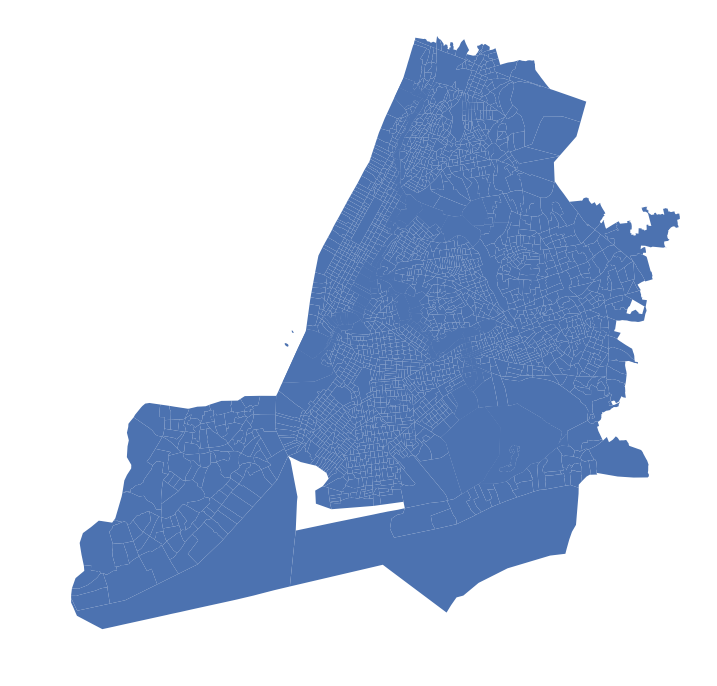

In [4]:
boroughs = gpd.GeoDataFrame.from_file('data/geo_export_6a0697ea-672d-48dc-a714-6eba515bb448.shp')
tazjoined = gpd.sjoin(taz,boroughs)
tazjoined = tazjoined[tazjoined.boro_name != '' ]
tazjoined.reset_index(drop=True,inplace=True)

fig, ax = plt.subplots(figsize=(12,12))
tazjoined.plot(ax=ax)
plt.axis('off')

In [5]:
TaxiData = pd.read_csv('data/AllTaxiData.csv')
TaxiData.drop('Unnamed: 0', axis=1,inplace=True)
TaxiData.head()

,ID,TotalTime,dolonlat,dropoff_datetime,fare_amount,passenger_count,pickup_datetime,pulonlat,trip_distance
0,0,0 days 00:11:16.000000000,"('-73.98260498046875', '40.773200988769531')",2015-06-19 20:11:17,11.0,1,2015-06-19 20:00:01,"('-74.004478454589844', '40.742042541503906')",2.8
1,1,0 days 00:19:28.000000000,"('-73.959709167480469', '40.771114349365234')",2015-06-19 20:19:29,26.5,1,2015-06-19 20:00:01,"('-74.012016296386719', '40.720310211181641')",8.5
2,2,0 days 00:00:14.000000000,"('-73.970542907714844', '40.793243408203125')",2015-06-19 20:00:15,2.5,2,2015-06-19 20:00:01,"('-73.970535278320312', '40.793262481689453')",0.0
3,3,0 days 00:05:15.000000000,"('-73.992424011230469', '40.748493194580078')",2015-06-19 20:05:16,5.5,1,2015-06-19 20:00:01,"('-73.992919921875', '40.757949829101563')",0.9
4,4,0 days 00:11:18.000000000,"('-73.969406127929688', '40.768718719482422')",2015-06-19 20:11:19,9.5,2,2015-06-19 20:00:01,"('-73.980270385742187', '40.748641967773438')",1.6


In [6]:
#fix formatting

def parseTuple(tup):
    tup = tup.replace('(','').replace(')','').replace("'",'')
    tup = tup.split(',')
    x,y = tup
    a= float(x)
    b= float(y)
    return((a,b))

TaxiData['dolonlat'] = TaxiData.dolonlat.apply(parseTuple)
TaxiData['pulonlat'] = TaxiData.pulonlat.apply(parseTuple)
TaxiData.head()

,ID,TotalTime,dolonlat,dropoff_datetime,fare_amount,passenger_count,pickup_datetime,pulonlat,trip_distance
0,0,0 days 00:11:16.000000000,"(-73.98260498046875, 40.77320098876953)",2015-06-19 20:11:17,11.0,1,2015-06-19 20:00:01,"(-74.00447845458984, 40.742042541503906)",2.8
1,1,0 days 00:19:28.000000000,"(-73.95970916748047, 40.771114349365234)",2015-06-19 20:19:29,26.5,1,2015-06-19 20:00:01,"(-74.01201629638672, 40.72031021118164)",8.5
2,2,0 days 00:00:14.000000000,"(-73.97054290771484, 40.793243408203125)",2015-06-19 20:00:15,2.5,2,2015-06-19 20:00:01,"(-73.97053527832031, 40.79326248168945)",0.0
3,3,0 days 00:05:15.000000000,"(-73.99242401123047, 40.74849319458008)",2015-06-19 20:05:16,5.5,1,2015-06-19 20:00:01,"(-73.992919921875, 40.75794982910156)",0.9
4,4,0 days 00:11:18.000000000,"(-73.96940612792969, 40.76871871948242)",2015-06-19 20:11:19,9.5,2,2015-06-19 20:00:01,"(-73.98027038574219, 40.74864196777344)",1.6


In [7]:
#Convert lat/long to geometry for geopandas join

TaxiData['geometryStart'] = TaxiData.dolonlat.apply(lambda x: shapely.geometry.Point(x))
TaxiData['geometryFinish'] = TaxiData.pulonlat.apply(lambda x: shapely.geometry.Point(x))
TaxiData.head()

,ID,TotalTime,dolonlat,dropoff_datetime,fare_amount,passenger_count,pickup_datetime,pulonlat,trip_distance,geometryStart,geometryFinish
0,0,0 days 00:11:16.000000000,"(-73.98260498046875, 40.77320098876953)",2015-06-19 20:11:17,11.0,1,2015-06-19 20:00:01,"(-74.00447845458984, 40.742042541503906)",2.8,POINT (-73.98260498046875 40.77320098876953),POINT (-74.00447845458984 40.74204254150391)
1,1,0 days 00:19:28.000000000,"(-73.95970916748047, 40.771114349365234)",2015-06-19 20:19:29,26.5,1,2015-06-19 20:00:01,"(-74.01201629638672, 40.72031021118164)",8.5,POINT (-73.95970916748047 40.77111434936523),POINT (-74.01201629638672 40.72031021118164)
2,2,0 days 00:00:14.000000000,"(-73.97054290771484, 40.793243408203125)",2015-06-19 20:00:15,2.5,2,2015-06-19 20:00:01,"(-73.97053527832031, 40.79326248168945)",0.0,POINT (-73.97054290771484 40.79324340820312),POINT (-73.97053527832031 40.79326248168945)
3,3,0 days 00:05:15.000000000,"(-73.99242401123047, 40.74849319458008)",2015-06-19 20:05:16,5.5,1,2015-06-19 20:00:01,"(-73.992919921875, 40.75794982910156)",0.9,POINT (-73.99242401123047 40.74849319458008),POINT (-73.992919921875 40.75794982910156)
4,4,0 days 00:11:18.000000000,"(-73.96940612792969, 40.76871871948242)",2015-06-19 20:11:19,9.5,2,2015-06-19 20:00:01,"(-73.98027038574219, 40.74864196777344)",1.6,POINT (-73.96940612792969 40.76871871948242),POINT (-73.98027038574219 40.74864196777344)


In [8]:
#convert TotalTime to seconds

TaxiData['pickup_datetime'] = pd.to_datetime(TaxiData.pickup_datetime)
TaxiData['dropoff_datetime'] = pd.to_datetime(TaxiData.dropoff_datetime)

TaxiData['TotalTime']= (TaxiData.dropoff_datetime - TaxiData.pickup_datetime).dt.total_seconds()
TaxiData.head()

,ID,TotalTime,dolonlat,dropoff_datetime,fare_amount,passenger_count,pickup_datetime,pulonlat,trip_distance,geometryStart,geometryFinish
0,0,676.0,"(-73.98260498046875, 40.77320098876953)",2015-06-19 20:11:17,11.0,1,2015-06-19 20:00:01,"(-74.00447845458984, 40.742042541503906)",2.8,POINT (-73.98260498046875 40.77320098876953),POINT (-74.00447845458984 40.74204254150391)
1,1,1168.0,"(-73.95970916748047, 40.771114349365234)",2015-06-19 20:19:29,26.5,1,2015-06-19 20:00:01,"(-74.01201629638672, 40.72031021118164)",8.5,POINT (-73.95970916748047 40.77111434936523),POINT (-74.01201629638672 40.72031021118164)
2,2,14.0,"(-73.97054290771484, 40.793243408203125)",2015-06-19 20:00:15,2.5,2,2015-06-19 20:00:01,"(-73.97053527832031, 40.79326248168945)",0.0,POINT (-73.97054290771484 40.79324340820312),POINT (-73.97053527832031 40.79326248168945)
3,3,315.0,"(-73.99242401123047, 40.74849319458008)",2015-06-19 20:05:16,5.5,1,2015-06-19 20:00:01,"(-73.992919921875, 40.75794982910156)",0.9,POINT (-73.99242401123047 40.74849319458008),POINT (-73.992919921875 40.75794982910156)
4,4,678.0,"(-73.96940612792969, 40.76871871948242)",2015-06-19 20:11:19,9.5,2,2015-06-19 20:00:01,"(-73.98027038574219, 40.74864196777344)",1.6,POINT (-73.96940612792969 40.76871871948242),POINT (-73.98027038574219 40.74864196777344)


In [9]:
taz.sort_values('TAZCE10')

,STATEFP10,COUNTYFP10,MPOCE10,TADCE10,TAZCE10,GEOID10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry
index_left,,,,,,,,,,,,,
3934,36,055,36197700,DOWNTOWN,00000001,3605500000001,G6320,S,163122,0,+43.1545584,-077.6173910,"POLYGON ((-77.61729099999999 43.152666, -77.61..."
5066,36,071,72567200,00000132,00000001,3607100000001,G6320,S,3044389,6524,+41.4351599,-074.1815294,"POLYGON ((-74.178718 41.427886, -74.178907 41...."
7658,36,029,36197401,00000100,00000001,3602900000001,G6320,S,86180,0,+42.8816787,-078.8776151,"POLYGON ((-78.876566 42.878953, -78.876587 42...."
6520,36,067,72698500,00000001,00000001,3606700000001,G6320,S,19095624,3244260,+43.1309916,-076.4577213,"POLYGON ((-76.41927 43.158503, -76.419106 43.1..."
5808,36,109,36199200,00000108,00000001,3610900000001,G6320,S,6035038,16539062,+42.5909960,-076.6242259,"POLYGON ((-76.636972 42.624574, -76.633608 42...."
4765,36,001,36197300,00000165,00000001,3600100000001,G6320,S,250637,0,+42.6509439,-073.7591074,"POLYGON ((-73.755415 42.651257, -73.7554749999..."
1311,36,015,36197500,00000003,00000001,3601500000001,G6320,S,3491375,12351,+42.1505598,-076.9144245,"POLYGON ((-76.909662 42.144989, -76.909786 42...."
963,36,065,26360430,00000104,00000001,3606500000001,G6320,S,370905,0,+43.1055230,-075.2317722,"POLYGON ((-75.238857 43.106019, -75.238968 43...."
3972,36,055,36197700,DOWNTOWN,00000002,3605500000002,G6320,S,86415,22437,+43.1575815,-077.6129479,"POLYGON ((-77.61466 43.157861, -77.615408 43.1..."


In [10]:
taz[['GEOID10','geometry']].head()

,GEOID10,geometry
index_left,,
0,3607700590202,"POLYGON ((-75.024045 42.754126, -75.01915 42.7..."
1,3607700590300,"POLYGON ((-75.244421 42.875085, -75.244457 42...."
2,3607700590400,"POLYGON ((-75.06633099999999 42.591812, -75.06..."
3,3607700591500,"POLYGON ((-75.39650499999999 42.491529, -75.39..."
4,3607700590700,"POLYGON ((-74.693719 42.637015, -74.691255 42...."


In [11]:
# separate into two geodataframes for joins
StartGDF = gpd.GeoDataFrame(TaxiData,geometry='geometryStart')
StartGDF = gpd.sjoin(StartGDF,taz[['GEOID10','geometry']])
StartGDF.drop('index_right',axis=1,inplace=True)
StartGDF.rename(columns={'GEOID10':'StartTAZ'},inplace=True)

FinishGDF = gpd.GeoDataFrame(TaxiData,geometry='geometryFinish')
FinishGDF = gpd.sjoin(FinishGDF,taz[['GEOID10','geometry']])
FinishGDF.drop('index_right',axis=1,inplace=True)
FinishGDF.rename(columns={'GEOID10':'FinishTAZ'},inplace=True)


In [12]:
JoinedTaxi = StartGDF.join(FinishGDF[['ID','FinishTAZ']],on='ID',rsuffix='_delete')
JoinedTaxi.drop('ID_delete',axis=1,inplace=True)
JoinedTaxi.head()

,ID,TotalTime,dolonlat,dropoff_datetime,fare_amount,passenger_count,pickup_datetime,pulonlat,trip_distance,geometryStart,geometryFinish,StartTAZ,FinishTAZ
0,0,676.0,"(-73.98260498046875, 40.77320098876953)",2015-06-19 20:11:17,11.0,1,2015-06-19 20:00:01,"(-74.00447845458984, 40.742042541503906)",2.80,POINT (-73.98260498046875 40.77320098876953),POINT (-74.00447845458984 40.74204254150391),3606100014900,3606100008300
7,7,1164.0,"(-73.98202514648438, 40.77110290527344)",2015-06-19 20:19:26,14.5,3,2015-06-19 20:00:02,"(-73.98319244384766, 40.74158477783203)",3.00,POINT (-73.98202514648438 40.77110290527344),POINT (-73.98319244384766 40.74158477783203),3606100014900,3606100006800
26,26,422.0,"(-73.98223876953125, 40.77113342285156)",2015-06-19 20:07:08,7.0,5,2015-06-19 20:00:06,"(-73.98103332519531, 40.779571533203125)",1.34,POINT (-73.98223876953125 40.77113342285156),POINT (-73.98103332519531 40.77957153320312),3606100014900,3606100015900
75,75,448.0,"(-73.98175048828125, 40.771331787109375)",2015-06-19 20:07:40,7.0,1,2015-06-19 20:00:12,"(-73.96311950683594, 40.76591873168945)",1.21,POINT (-73.98175048828125 40.77133178710938),POINT (-73.96311950683594 40.76591873168945),3606100014900,3606100011800
211,211,116.0,"(-73.98405456542969, 40.773780822753906)",2015-06-19 20:02:27,4.0,1,2015-06-19 20:00:31,"(-73.99099731445312, 40.770870208740234)",0.50,POINT (-73.98405456542969 40.77378082275391),POINT (-73.99099731445312 40.77087020874023),3606100014900,3606100013500


In [13]:
# TAZjoined.to_csv('TAZjoined.csv')

In [14]:
#Generage Flow Table
d = {'TotalTime':'AverageTime', 'trip_distance':'AverageDistance','passenger_count':'TotalPassengers','fare_amount':'AverageFare'}
GroupedTAZ = JoinedTaxi.groupby(by=['StartTAZ','FinishTAZ']).agg({'TotalTime':'mean', 'trip_distance':'mean','passenger_count':'sum','fare_amount':'mean'}).rename(columns=d)
GroupedTAZ.reset_index(inplace=True)
GroupedTAZ.head()

,StartTAZ,FinishTAZ,TotalPassengers,AverageDistance,AverageTime,AverageFare
0,3600500000200,3606100006800,1,6.4,1028.0,20.0
1,3600500000200,3606100007100,4,11.1,3007.0,41.0
2,3600500000200,3606100008200,1,10.5,2052.0,35.0
3,3600500000200,3606100008400,1,2.3,394.0,8.5
4,3600500000200,3606100008700,1,17.9,2264.0,50.5


In [15]:
tazpop = pd.read_csv('data/TAZ_w_pop.csv',usecols=['TOTPOP_CY','GEOID10'])
tazpop.rename(columns={'GEOID10':'StartTAZ'},inplace=True)
tazpop['StartTAZ'] = tazpop.StartTAZ.apply(lambda x: str(x)) # have to convert due to arcgis
tazpop.sort_values('StartTAZ').head()

,StartTAZ,TOTPOP_CY
2265,3600500000100,10506.0
2257,3600500000200,4888.0
2259,3600500000400,6338.0
2218,3600500001600,6028.0
1983,3600500001900,1941.0


In [16]:
#have to convert TAZ to Int for merge

# GroupedTAZ['StartTAZ'] = GroupedTAZ.StartTAZ.apply(lambda x: int(x))
# GroupedTAZ['FinishTAZ'] = GroupedTAZ.FinishTAZ.apply(lambda x: int(x))
# GroupedTAZ.head()

In [17]:
# Join Population to TAZ
TAZjoined = GroupedTAZ.merge(tazpop,on='StartTAZ')
TAZjoined.rename(columns={'TOTPOP_CY':'OriginPopulation'},inplace=True)
TAZjoined.fillna(0,inplace=True)
TAZjoined.head()

,StartTAZ,FinishTAZ,TotalPassengers,AverageDistance,AverageTime,AverageFare,OriginPopulation
0,3600500000200,3606100006800,1,6.4,1028.0,20.0,4888.0
1,3600500000200,3606100007100,4,11.1,3007.0,41.0,4888.0
2,3600500000200,3606100008200,1,10.5,2052.0,35.0,4888.0
3,3600500000200,3606100008400,1,2.3,394.0,8.5,4888.0
4,3600500000200,3606100008700,1,17.9,2264.0,50.5,4888.0


In [18]:
#bars from enigma
bars = pd.read_csv('data/TrimmedBars.csv',usecols=['Premises_N','Longitude','Latitude'])
bars['longlat'] = list(zip(bars.Longitude, bars.Latitude))
bars['geometry'] = bars.longlat.apply(lambda x: shapely.geometry.Point(x))
bars = gpd.GeoDataFrame(bars)
bars.head()

,Premises_N,Latitude,Longitude,longlat,geometry
0,KENNETH MCPARTLAN TAVERN CORP,40.818850,-73.928023,"(-73.9280225703, 40.8188496305)",POINT (-73.9280225703 40.8188496305)
1,GLACKENS BAR & GRILL CORP,40.818940,-73.928375,"(-73.9283752049, 40.8189395186)",POINT (-73.92837520489999 40.8189395186)
2,STEBAR FOOD CORP,40.800418,-73.910742,"(-73.9107424039, 40.8004178483)",POINT (-73.9107424039 40.8004178483)
3,LA LECHONERA CRIOLLA INC,40.843393,-73.903519,"(-73.9035191554, 40.8433926669)",POINT (-73.90351915540001 40.8433926669)
4,EL DIAMANTE RESTAURANT CORP,40.850702,-73.894171,"(-73.8941708951, 40.8507021199)",POINT (-73.8941708951 40.8507021199)


In [19]:
TAZjoined['FinishTAZ'] = TAZjoined.FinishTAZ.apply(lambda x: int(x))
TAZjoined.dtypes

StartTAZ             object
FinishTAZ             int64
TotalPassengers       int64
AverageDistance     float64
AverageTime         float64
AverageFare         float64
OriginPopulation    float64
dtype: object

In [20]:
barJoined = gpd.sjoin(bars,taz[['GEOID10','geometry']])
barJoined = barJoined[['geometry','GEOID10']].groupby('GEOID10').count()
barJoined.reset_index(inplace=True)
barJoined.rename(columns={'geometry':'DestinationBars','GEOID10':'FinishTAZ'},inplace=True)
barJoined['FinishTAZ'] = barJoined.FinishTAZ.apply(lambda x: int(x))

TAZFinal = TAZjoined.merge(barJoined,on='FinishTAZ')
TAZFinal.fillna(0,inplace=True)
TAZFinal.head()

,StartTAZ,FinishTAZ,TotalPassengers,AverageDistance,AverageTime,AverageFare,OriginPopulation,DestinationBars
0,3600500000200,3606100006800,1,6.40,1028.000000,20.000000,4888.0,36
1,3600500001900,3606100006800,2,7.25,1731.000000,24.500000,1941.0,36
2,3600500002300,3606100006800,1,0.90,150.000000,4.500000,5459.0,36
3,3600500002500,3606100006800,4,6.70,1076.333333,21.166667,5886.0,36
4,3600500004100,3606100006800,9,2.48,487.000000,9.333333,6444.0,36


In [21]:
taz['centroid'] = taz.geometry.centroid
taz[['GEOID10','centroid']].head()

,GEOID10,centroid
index_right,,
0,3607700590202,POINT (-74.97604025615017 42.74315069389705)
1,3607700590300,POINT (-75.10645993504093 42.82560314101772)
2,3607700590400,POINT (-75.19790313091103 42.67120975893241)
3,3607700591500,POINT (-75.29764744184041 42.49737385078526)
4,3607700590700,POINT (-74.79015693007182 42.56166664979881)


In [22]:
# Convert back to objects
TAZFinal['StartTAZ'] = TAZFinal.StartTAZ.apply(lambda x: str(x))
TAZFinal['FinishTAZ'] = TAZFinal.FinishTAZ.apply(lambda x: str(x))
TAZFinal.dtypes

StartTAZ             object
FinishTAZ            object
TotalPassengers       int64
AverageDistance     float64
AverageTime         float64
AverageFare         float64
OriginPopulation    float64
DestinationBars       int64
dtype: object

In [23]:
taz.dtypes

STATEFP10     object
COUNTYFP10    object
MPOCE10       object
TADCE10       object
TAZCE10       object
GEOID10       object
MTFCC10       object
FUNCSTAT10    object
ALAND10        int64
AWATER10       int64
INTPTLAT10    object
INTPTLON10    object
geometry      object
centroid      object
dtype: object

In [24]:
TAZFinal2 = TAZFinal.merge(taz[['GEOID10','centroid']],left_on='StartTAZ',right_on='GEOID10')
TAZFinal2.rename(columns={'centroid':'StartPoint'},inplace=True)
TAZFinal2 = TAZFinal2.merge(taz[['GEOID10','centroid']],left_on='FinishTAZ',right_on='GEOID10')
TAZFinal2.rename(columns={'centroid':'FinishPoint'},inplace=True)
TAZFinal2.drop(['GEOID10_x','GEOID10_y'],axis=1,inplace=True)
TAZFinal2.head()

,StartTAZ,FinishTAZ,TotalPassengers,AverageDistance,AverageTime,AverageFare,OriginPopulation,DestinationBars,StartPoint,FinishPoint
0,3600500000200,3606100006800,1,6.40,1028.000000,20.000000,4888.0,36,POINT (-73.86000330820553 40.80588752047242),POINT (-73.9840802591542 40.74043661734395)
1,3600500001900,3606100006800,2,7.25,1731.000000,24.500000,1941.0,36,POINT (-73.90958766603121 40.80124256559512),POINT (-73.9840802591542 40.74043661734395)
2,3600500002300,3606100006800,1,0.90,150.000000,4.500000,5459.0,36,POINT (-73.9258461389568 40.80908431818972),POINT (-73.9840802591542 40.74043661734395)
3,3600500002500,3606100006800,4,6.70,1076.333333,21.166667,5886.0,36,POINT (-73.92087816464176 40.80700286223013),POINT (-73.9840802591542 40.74043661734395)
4,3600500004100,3606100006800,9,2.48,487.000000,9.333333,6444.0,36,POINT (-73.91940998857129 40.81138557966759),POINT (-73.9840802591542 40.74043661734395)


In [25]:
# Create Flow Matrix
FlowMatrix = pd.pivot_table(TAZFinal2,values='DestinationBars',index='StartTAZ',columns='FinishTAZ')
FlowMatrix.fillna(0,inplace=True) # there are a ton of n/a values for a 1000x1000 matrix
FlowMatrix.head()

FinishTAZ,3600500001900,3600500002500,3600500002702,3600500003900,3600500004300,3600500005100,3600500006100,3600500006301,3600500006302,3600500006303,...,3608100120500,3608100122701,3608100134700,3608100141701,3608100145900,3608100150702,3608500002002,3608500015100,3608500017011,3611900001502
StartTAZ,,,,,,,,,,,,,,,,,,,,,
3600500000200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3600500000400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3600500001600,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3600500001900,9.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3600500002000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
# Create Distance Matrix, could also be substituted by average fare etc
DistanceMatrix = pd.pivot_table(TAZFinal2,values='AverageDistance',index='StartTAZ',columns='FinishTAZ')
# FlowMatrix.fillna(0,inplace=True) # there are a ton of n/a values for a 1000x1000 matrix
DistanceMatrix.head()

FinishTAZ,3600500001900,3600500002500,3600500002702,3600500003900,3600500004300,3600500005100,3600500006100,3600500006301,3600500006302,3600500006303,...,3608100120500,3608100122701,3608100134700,3608100141701,3608100145900,3608100150702,3608500002002,3608500015100,3608500017011,3611900001502
StartTAZ,,,,,,,,,,,,,,,,,,,,,
3600500000200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3600500000400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3600500001600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3600500001900,0.01,NaN,NaN,NaN,NaN,NaN,1.3,NaN,8.06,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3600500002000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
# tazjoined[['geometry','GEOID10']].to_file('data/tazjoined2.geojson', driver="GeoJSON")

In [28]:
# TAZFinal2.to_csv('data/FlowData.csv')

In [33]:
#Create line geometries for geopandas
def convertShp(x):
    a = shapely.geometry.mapping(x).get('coordinates')
    return(a)

TAZFinal2['geomA'] = TAZFinal2.StartPoint.apply(convertShp)
TAZFinal2['geomb'] = TAZFinal2.FinishPoint.apply(convertShp)

def makeLine(x):
    return(shapely.geometry.LineString([x[0],x[1]]))

TAZFinal2['geometry'] = TAZFinal2[['geomA','geomb']].apply(makeLine,axis=1)

#separate lat and long for Kepler GL visualization
TAZFinal2['A_longitude'] = TAZFinal2.geomA.apply(lambda x: x[0])
TAZFinal2['A_latitude'] = TAZFinal2.geomA.apply(lambda x: x[1])
TAZFinal2['B_longitude'] = TAZFinal2.geomb.apply(lambda x: x[0])
TAZFinal2['B_latitude'] = TAZFinal2.geomb.apply(lambda x: x[1])

KeplerGL = TAZFinal2.drop(['StartPoint', 'FinishPoint', 'geomA', 'geomb', 'geometry'],axis=1)
TAZFinal2.drop(['geomA','geomb'],axis=1,inplace=True)

TAZFinal2.head()

,StartTAZ,FinishTAZ,TotalPassengers,AverageDistance,AverageTime,AverageFare,OriginPopulation,DestinationBars,StartPoint,FinishPoint,geomA,geomb,geometry
0,3600500000200,3606100006800,1,6.40,1028.000000,20.000000,4888.0,36,POINT (-73.86000330820553 40.80588752047242),POINT (-73.9840802591542 40.74043661734395),"(-73.86000330820553, 40.80588752047242)","(-73.9840802591542, 40.74043661734395)",LINESTRING (-73.86000330820553 40.805887520472...
1,3600500001900,3606100006800,2,7.25,1731.000000,24.500000,1941.0,36,POINT (-73.90958766603121 40.80124256559512),POINT (-73.9840802591542 40.74043661734395),"(-73.90958766603121, 40.801242565595125)","(-73.9840802591542, 40.74043661734395)",LINESTRING (-73.90958766603121 40.801242565595...
2,3600500002300,3606100006800,1,0.90,150.000000,4.500000,5459.0,36,POINT (-73.9258461389568 40.80908431818972),POINT (-73.9840802591542 40.74043661734395),"(-73.9258461389568, 40.80908431818972)","(-73.9840802591542, 40.74043661734395)",LINESTRING (-73.9258461389568 40.8090843181897...
3,3600500002500,3606100006800,4,6.70,1076.333333,21.166667,5886.0,36,POINT (-73.92087816464176 40.80700286223013),POINT (-73.9840802591542 40.74043661734395),"(-73.92087816464176, 40.80700286223013)","(-73.9840802591542, 40.74043661734395)",LINESTRING (-73.92087816464176 40.807002862230...
4,3600500004100,3606100006800,9,2.48,487.000000,9.333333,6444.0,36,POINT (-73.91940998857129 40.81138557966759),POINT (-73.9840802591542 40.74043661734395),"(-73.91940998857129, 40.81138557966759)","(-73.9840802591542, 40.74043661734395)",LINESTRING (-73.91940998857129 40.811385579667...


In [39]:
# Export Kepler GL for data visulation in third party software
# KeplerGL.to_csv('data/KeplerGL.csv')

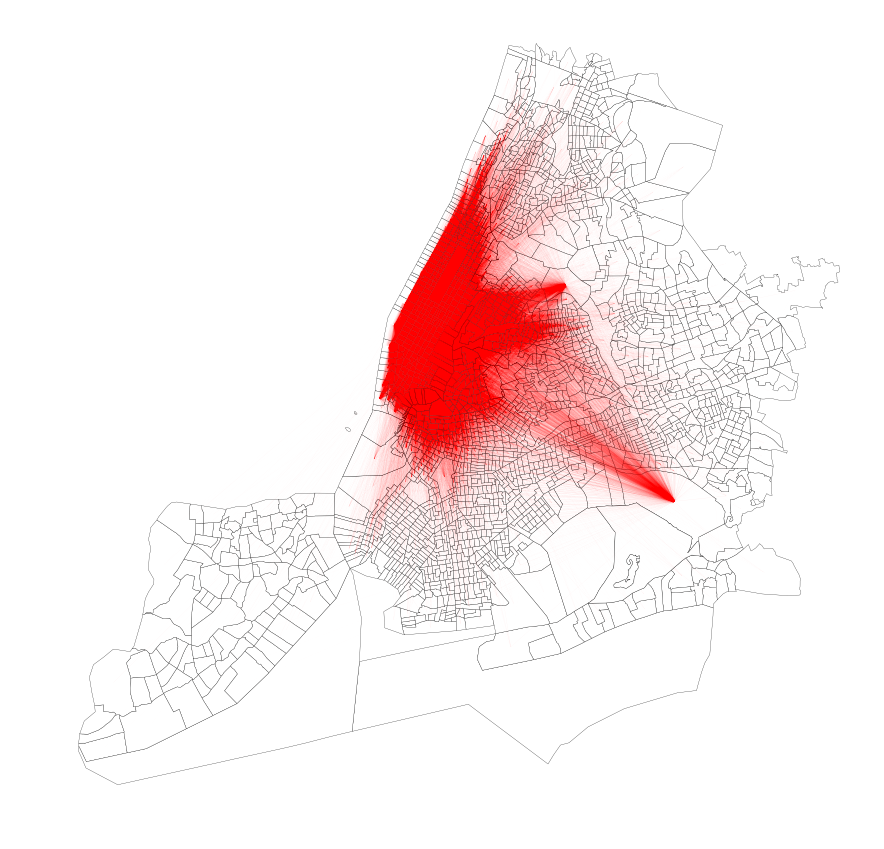

In [ ]:
flow_GDF = gpd.GeoDataFrame(TAZFinal2)

fig,ax = plt.subplots(figsize=(15,15))

w = (flow_GDF.TotalPassengers / flow_GDF.TotalPassengers.max()) * 10
flow_GDF.plot(lw=w,color='red',alpha=0.05,ax=ax)
tazjoined.plot(color='white',edgecolor='black',lw=0.25,ax=ax)

plt.axis('off')
plt.savefig('data/FlowMap.png')

In [44]:
# What TAZ gets the most flow?
TopTAZ = flow_GDF.sort_values('TotalPassengers',ascending=False).iloc[1]
TopTAZ

StartTAZ                                                3606100010100
FinishTAZ                                               3606100012900
TotalPassengers                                                   276
AverageDistance                                               1.76684
AverageTime                                                   520.943
AverageFare                                                   8.49367
OriginPopulation                                                 1720
DestinationBars                                                    18
StartPoint               POINT (-73.99154124315282 40.74973140264049)
FinishPoint              POINT (-74.00003074901872 40.76490991582867)
geomA                        (-73.99154124315282, 40.749731402640485)
geomb                        (-74.00003074901872, 40.764909915828675)
geometry            LINESTRING (-73.99154124315282 40.749731402640...
A_longitude                                                  -73.9915
A_latitude          

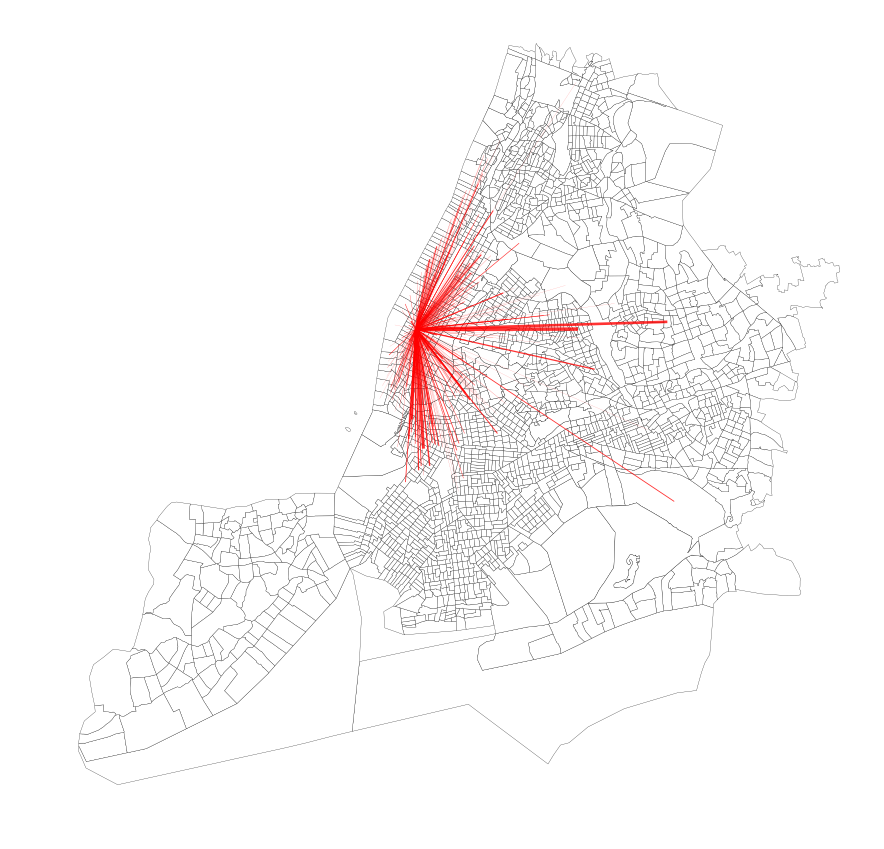

In [62]:
#Plot the Top TAZ
fig,ax = plt.subplots(figsize=(15,15))

w = (flow_GDF.TotalPassengers / flow_GDF.TotalPassengers.max()) * 30


flow_GDF[(flow_GDF.StartTAZ != flow_GDF.FinishTAZ)&(flow_GDF.StartTAZ == '3606100010100')].plot(lw=w,color='red',alpha=0.8,ax=ax)
tazjoined.plot(color='white',edgecolor='black',lw=0.25,ax=ax)

plt.axis('off')

# plt.xlim(-74.003294, -73.992811) 
# plt.ylim(40.716859,40.724394)

plt.savefig('data/FlowMap2.png')